# Project Analysis

#### The Dataset
The dataset contains information on shooting incidents in the US between the years 1966-2016 .
[link to the data source](https://www.kaggle.com/spscientist/students-performance-in-exams)

We read the data from a github repository

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [274]:
data=pd.read_csv("mass_shooting_events_stanford_msa_release_06142016.csv")
data=data[["Average Shooter Age",'CaseID',"Shooter Sex",'Day of Week', "Shooter Race",'Longitude','Latitude', "Number of Victim Fatalities","Number of Victims Injured","Total Number of Victims", "State","City","Place Type","Date","Fate of Shooter at the scene"]]
data.head()

,Average Shooter Age,CaseID,Shooter Sex,Day of Week,Shooter Race,Longitude,Latitude,Number of Victim Fatalities,Number of Victims Injured,Total Number of Victims,State,City,Place Type,Date,Fate of Shooter at the scene
0,25,1.0,Male,Monday,White American or European American,-97.844159,30.198887,16.0,32.0,48.0,Texas,Austin,College/University/Adult education,8/1/1966,Deceased
1,18,2.0,Male,Saturday,White American or European American,-111.816320,33.422687,5.0,1.0,6.0,Arizona,Mesa,College/University/Adult education,11/12/1966,Arrested
2,23,3.0,Male,Sunday,Black American or African American,-89.931474,30.068724,9.0,13.0,22.0,Louisiana,New Orleans,Government facility,12/31/72,Deceased
3,14,4.0,Male,Thursday,Unknown,-87.688181,41.839280,1.0,3.0,4.0,Illinois,Chicago,Primary school,1/17/74,Arrested
4,17,5.0,Male,Monday,White American or European American,-78.432139,42.081854,3.0,7.0,10.0,New York,Olean,Secondary school,12/30/74,Arrested


### Treat missing values

Check if there are missing values:

In [275]:
data.isnull().sum().sort_values(ascending=False)

Fate of Shooter at the scene    40
Date                            40
Place Type                      40
City                            40
State                           40
Total Number of Victims         40
Number of Victims Injured       40
Number of Victim Fatalities     40
Latitude                        40
Longitude                       40
Shooter Race                    40
Day of Week                     40
Shooter Sex                     40
CaseID                          40
Average Shooter Age             40
dtype: int64

We can see there are a lot of 'na's' in each column. We used dropna to treat them so we can analyse our data with no problems. When we started working with the data we noticed a problematic row for the analysing so we droped it. 

In [276]:
data=data.drop(data.index[175]).reset_index()
data=data.dropna().reset_index()

We also had a lot of 'Unknown' values. Let's check how many we have and treat them accordingly:

In [277]:
data.isin(["Unknown"]).sum()

level_0                          0
index                            0
Average Shooter Age             30
CaseID                           0
Shooter Sex                     22
Day of Week                      0
Shooter Race                    44
Longitude                        0
Latitude                         0
Number of Victim Fatalities      0
Number of Victims Injured        0
Total Number of Victims          0
State                            0
City                             0
Place Type                       0
Date                             0
Fate of Shooter at the scene     0
dtype: int64

The most important column to have all it's values is the 'Average Shooter Age' column, so we droped all rows where the 'Average Shooter Age' column has an 'Unknown' value. 

In [278]:
data = data.drop(data[data['Average Shooter Age'].isin(['Unknown'])].index)

Now let's see what's the sitation.

In [279]:
data.isin(["Unknown"]).sum()

level_0                          0
index                            0
Average Shooter Age              0
CaseID                           0
Shooter Sex                      0
Day of Week                      0
Shooter Race                    17
Longitude                        0
Latitude                         0
Number of Victim Fatalities      0
Number of Victims Injured        0
Total Number of Victims          0
State                            0
City                             0
Place Type                       0
Date                             0
Fate of Shooter at the scene     0
dtype: int64

We can proceed with that.

### Fixing data types
Check if any of the data types need to be fixed:

In [280]:
data.dtypes

level_0                           int64
index                             int64
Average Shooter Age              object
CaseID                          float64
Shooter Sex                      object
Day of Week                      object
Shooter Race                     object
Longitude                       float64
Latitude                        float64
Number of Victim Fatalities     float64
Number of Victims Injured       float64
Total Number of Victims         float64
State                            object
City                             object
Place Type                       object
Date                             object
Fate of Shooter at the scene     object
dtype: object

We noticed that the column  'date'  and  'Average Shooter Age'  are objects, so we wanted to change them to the relavent type: 
The column 'date' to datetime and the cloumn 'Average Shooter Age' to float. 

We'll need the day and month for later so we'll create new columns named date and month that specify which day and month incident case is. 

In [281]:
data["Date"]=pd.to_datetime(data.Date) 
data['Average Shooter Age'] = data['Average Shooter Age'].astype(float)
data["year"]=pd.DatetimeIndex(data.Date).year
data["month"]=pd.DatetimeIndex(data.Date).month
data["day"]=pd.DatetimeIndex(data.Date).day

### Merging categories 

When we were trying to understand the data, in some of the columns there were a few differant names for the same thing, which split the cases to a few differant ones. 
For example, in the column 'place type', there were a few names for incidents that happened in a Restaurant/Cafe, that basicly had the same name, so we merged them to be one. We used groupby just to see which differant names repeat themselves. 
That happened in a few differant columns. So we did that for each relavent column. 

In [282]:
data.groupby('Shooter Race')['Shooter Race'].count().sort_values()

Shooter Race
Asian American/Some other race                           1
Black American or African American/Unknown               1
White American or European American/Some other Race      1
Native American or Alaska Native                         3
Two or more races                                        3
Asian American                                          16
Unknown                                                 17
Some other race                                         23
Black American or African American                      74
White American or European American                    137
Name: Shooter Race, dtype: int64

In [283]:
data["Shooter Race"].replace({'Black American or African American/Unknown': 'Black American or African American'}, inplace=True)
data["Shooter Race"].replace({'Asian American/Some other race': 'Asian American'}, inplace=True)
data["Shooter Race"].replace({'White American or European American/Some other Race':'White American or European American'}, inplace=True)
data["Shooter Race"].replace({'Two or more races':'Some other race'}, inplace=True)
data["Shooter Race"].replace({'Unknown':'Some other race'}, inplace=True)

In [284]:
data.groupby('Place Type')['Place Type'].count().sort_values()

Place Type
Secondary School                                                        1
Retail/ Wholesale/Services facility\rand Primary school                 1
Entertainment Venue                                                     1
Retail/ Wholesale/Services facility                                     1
Restaurant/cafe                                                         1
Restaurant/Cafe                                                         1
Residential home/Neighborhood,\rRetail/ Wholesale/Services facility     1
Residential home/Neighborhood \rand Street/Highway                      1
Retail/Wholesale/Services facility\r/Residential home/Neighborhood      2
Residential Home/Neighborhood                                           2
Public transportation                                                   4
Park/Wildness                                                           4
Medical/Care                                                            4
Military facility          

In [285]:
data["Place Type"].replace({'Restaurant/Cafe': 'Restaurant/cafe'}, inplace=True)
data["Place Type"].replace({'Restaurant/Cafe?': 'Restaurant/cafe'}, inplace=True)
data["Place Type"].replace({'Residential Home/Neighborhood':'Residential home/Neighborhood'}, inplace=True)
data["Place Type"].replace({'Residential home/Neighborhood \rand Street/Highway':'Residential home/Neighborhood'}, inplace=True)
data["Place Type"].replace({'Residential home/Neighborhood,\rRetail/ Wholesale/Services facility':'Residential home/Neighborhood'}, inplace=True)
data["Place Type"].replace({'Retail/ Wholesale/Services facility':'Retail/Wholesale/Services facility'}, inplace=True)
data["Place Type"].replace({'Secondary School':'Secondary school'}, inplace=True)

In [286]:
data.groupby('Fate of Shooter at the scene')['Fate of Shooter at the scene'].count().sort_values()

Fate of Shooter at the scene
Arrested/Escaped         1
Escaped\r(Arrested)      1
Killed                   1
Escaped                 21
Arrested               118
Deceased               134
Name: Fate of Shooter at the scene, dtype: int64

In [287]:
data["Fate of Shooter at the scene"].replace({'Escaped\r(Arrested)':'Arrested/Escaped'}, inplace=True)
data["Fate of Shooter at the scene"].replace({'Killed':'Deceased'}, inplace=True)

## 2. Understanding the data

The first thing we want to check is how many cases each gender/race had. 

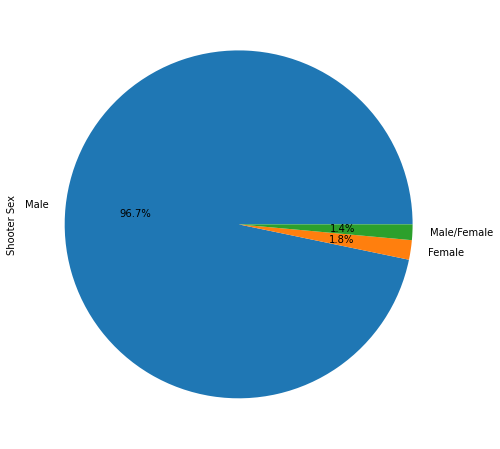

In [365]:
plt.figure(1, figsize=(10,8))
data['Shooter Sex'].value_counts().plot.pie(autopct='%1.1f%%')

As we can see, there is a huge difference between the shooting incidents done by men then by women. 



Let's present a nicer way to observe the data according to race. We'll adjust the lable rotation angle so the labels don't ovelap.

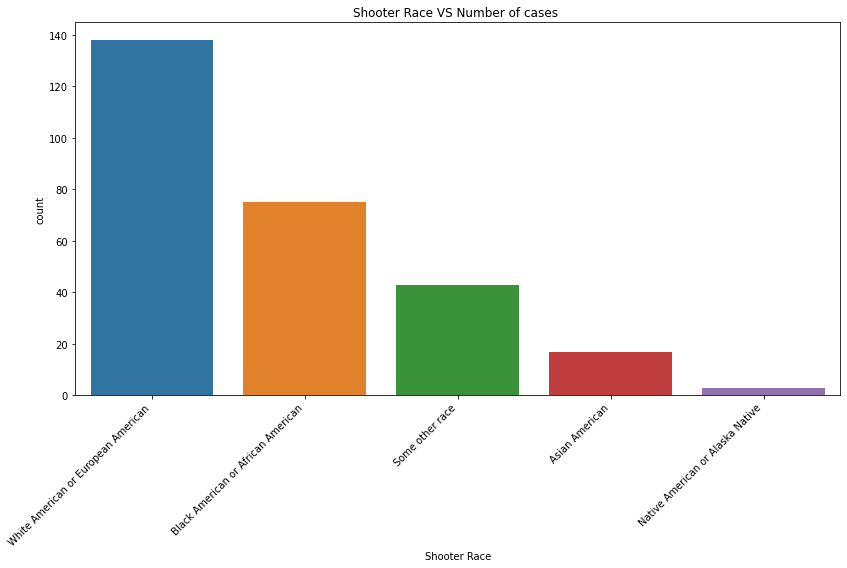

In [401]:
data["Shooter Race"].value_counts()
plt.figure(1, figsize=(12,8))
sns.countplot(x="Shooter Race",data=data) 
ax = sns.countplot('Shooter Race', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title("Shooter Race VS Number of cases ")
plt.tight_layout()
plt.show()

Which type of invironments do shooting incidents happen?

In [294]:
data.groupby("Place Type")[["CaseID"]].count().sort_values('CaseID',ascending=False)

,CaseID
Place Type,
Residential home/Neighborhood,89
College/University/Adult education,27
Secondary school,22
Company/Factory/Office,20
Government facility,20
Retail/Wholesale/Services facility,16
Primary school,16
Street/Highway,16
Entertainment venue,12


Notice that the first category (Residential home/Neighborhood) has 3 times as many cases as the second highest category (College/University/Adult education)! That was very surprising to us, so we wanted to check that further.

So is there a specific reason for this phenomenon? 

We started to check different directions, until we found an interesting one. 

In [295]:
data.groupby('month')[['CaseID']].count().sort_values('CaseID',ascending = False)

,CaseID
month,
2,46
3,34
12,28
4,24
1,23
8,22
10,21
11,19
5,17


##### Observation:
As we know, in the US the winters' months are from the end of December until the end of April. Obviously those are the coldest months of the year... 

Considering that most shooting incidents occur at home, it's logical that the most incidents will occur when the weather prevents people from leaving home. 

So we decided to dig deeper and check if there are more cases in the winter and inside. 

In [299]:
Res_home_or_NH_rows = data.loc[data["Place Type"]== "Residential home/Neighborhood"]
Res_home_or_NH_rows.groupby("month")[["Place Type"]].count().sort_values("Place Type", ascending = False)
#Incidents in "Residential home/Neighborhood" by month

,Place Type
month,
3,19
2,17
1,12
4,9
5,5
8,5
12,5
6,4
7,4


## First insight:
> - More incidents in Residential home/Neighborhood happen in the winter months. 

Were all the shooter's fate the same?

Let's check the fate of the shooters in the top 4 shooting places. 

Text(0.5, 1.0, 'The place type VS Number of cases ')

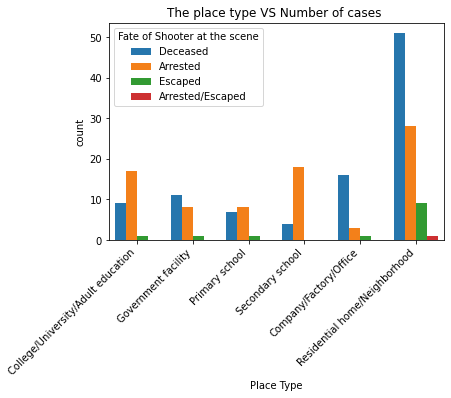

In [402]:
top_4_places=data[(data["Place Type"]=="Residential home/Neighborhood")| (data['Place Type']=='Secondary school') | (data['Place Type']=='College/University/Adult education') | (data['Place Type']=='Company/Factory/Office') | (data['Place Type']=='Government facility') |(data['Place Type']=='Primary school')]
illusration = sns.countplot(x=top_4_places['Place Type'],data=top_4_places,hue='Fate of Shooter at the scene',saturation=0.9)
illusration.set_xticklabels(illusration.get_xticklabels(), rotation=45, ha="right")
plt.title("The place type VS Number of cases ")

##### Observation:
As we can see, in educational places, there were more arrested shooters relatively to the other places than Deceased. 

So we decided to check if those places have something in common and found out that the age plays an important role. 

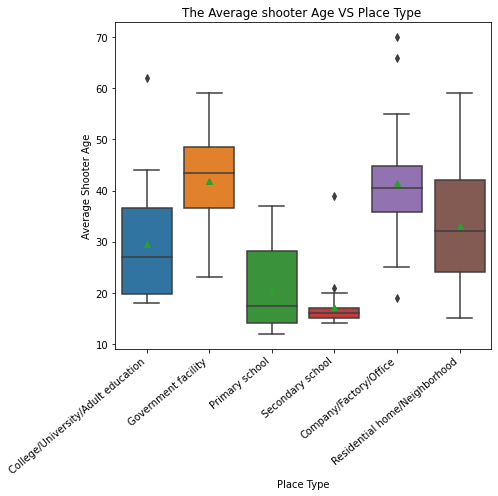

In [403]:
plt.figure(1, figsize=(7,7))
ax = sns.boxplot(x='Place Type', y='Average Shooter Age', data=top_4_places, showmeans=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('The Average shooter Age VS Place Type ')
plt.tight_layout()
plt.show()

In [389]:
print('According to the illustration the mean of the Average Shooter Age in each place is: ')
print('Secondary school:',top_4_places[top_4_places['Place Type']=='Secondary school']['Average Shooter Age'].mean())
print('Primary school:',top_4_places[top_4_places['Place Type']=='Primary school']['Average Shooter Age'].mean())
print('College/University/Adult education:',top_4_places[top_4_places['Place Type']=='College/University/Adult education']['Average Shooter Age'].mean())
print('Residential home/Neighborhood:',top_4_places[top_4_places['Place Type']=='Residential home/Neighborhood']['Average Shooter Age'].mean())
print('Company/Factory/Office:',top_4_places[top_4_places['Place Type']=='Company/Factory/Office']['Average Shooter Age'].mean())
print('Government facility:',top_4_places[top_4_places['Place Type']=='Government facility']['Average Shooter Age'].mean())

According to the illustration the mean of the Average Shooter Age in each place is: 
Secondary school: 17.318181818181817
Primary school: 20.5625
College/University/Adult education: 29.5
Residential home/Neighborhood: 33.08651685393258
Company/Factory/Office: 41.4
Government facility: 41.95


## Second insight:
> - The fate of the shooter may be influenced by his age. Apparently the police forces have more empathy towards the younger.   

#### We already proved that the shooter's fate is probably influenced by his age. Is the fate also influenced by other factors, like the
#### number of victims?

[Text(0, 0, '3.0'),
 Text(0, 0, '4.0'),
 Text(0, 0, '5.0'),
 Text(0, 0, '6.0'),
 Text(0, 0, '7.0'),
 Text(0, 0, '8.0'),
 Text(0, 0, '9.0'),
 Text(0, 0, '10.0'),
 Text(0, 0, '11.0'),
 Text(0, 0, '12.0'),
 Text(0, 0, '14.0'),
 Text(0, 0, '15.0'),
 Text(0, 0, '16.0'),
 Text(0, 0, '17.0'),
 Text(0, 0, '19.0'),
 Text(0, 0, '20.0'),
 Text(0, 0, '21.0'),
 Text(0, 0, '22.0'),
 Text(0, 0, '25.0'),
 Text(0, 0, '27.0'),
 Text(0, 0, '29.0'),
 Text(0, 0, '35.0'),
 Text(0, 0, '37.0'),
 Text(0, 0, '40.0'),
 Text(0, 0, '43.0'),
 Text(0, 0, '45.0'),
 Text(0, 0, '48.0'),
 Text(0, 0, '49.0'),
 Text(0, 0, '70.0')]

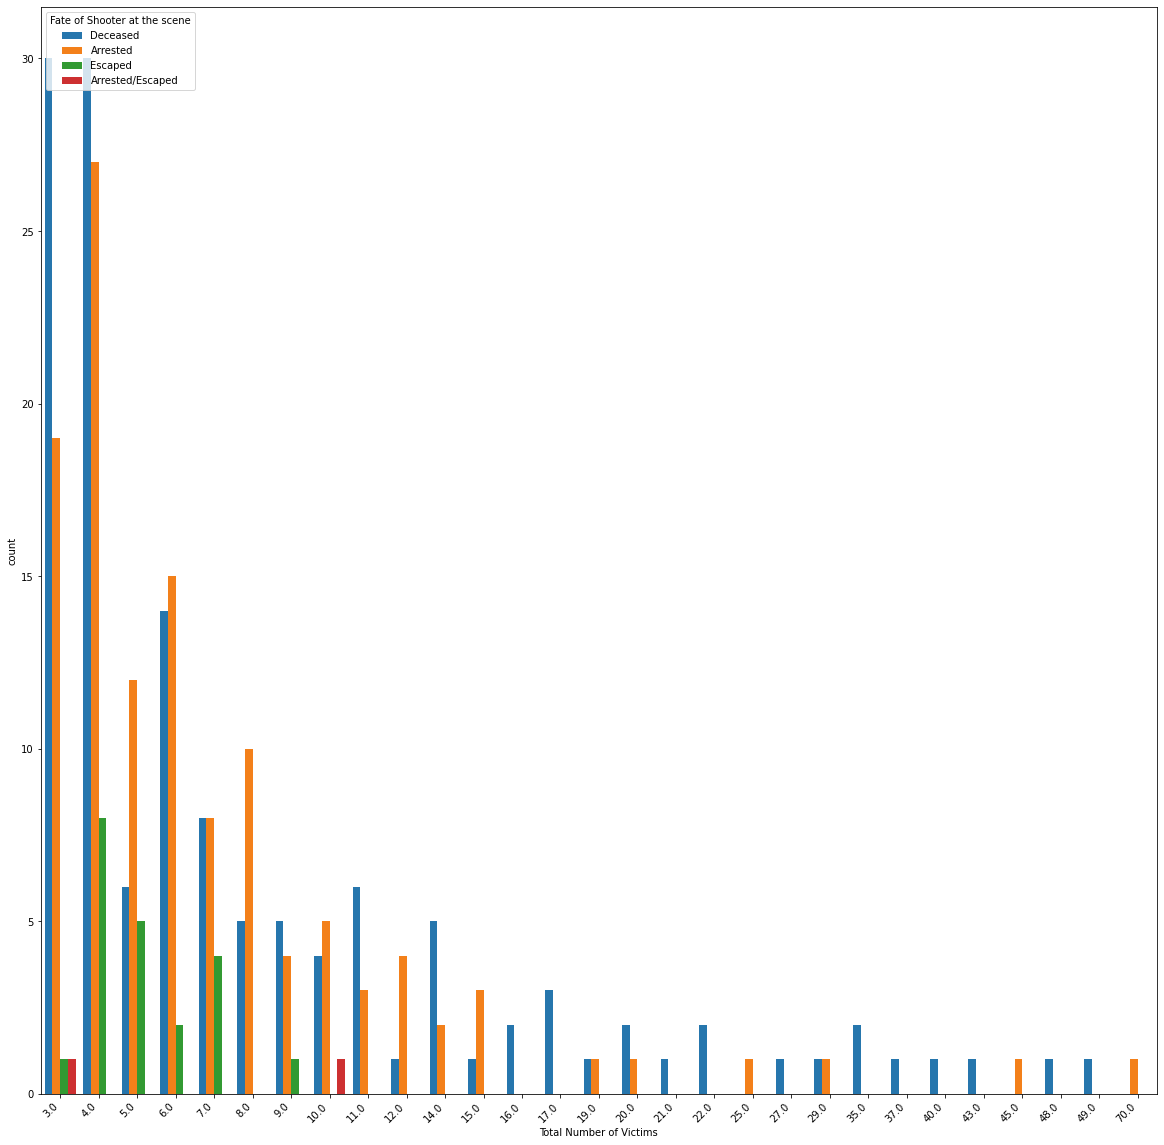

In [397]:
plt.figure(1, figsize=(20,20))
illusration = sns.countplot(x=data['Total Number of Victims'],data=data,hue='Fate of Shooter at the scene',saturation=0.9)
illusration.set_xticklabels(illusration.get_xticklabels(), rotation=45, ha="right")

##### Observation:
For the most part, it seems as if the more victims there are, the more the shooter finds himself dead by the end of the incident. That made sense to us so we decided to try and find a correlation so we can be sure. 

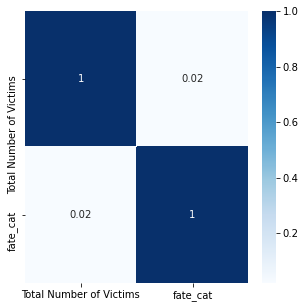

In [399]:
data["fate_cat"]=data["Fate of Shooter at the scene"].astype("category").cat.codes
features=["Total Number of Victims","fate_cat"]
correlation=data[features].corr().round(2)
plt.figure(1, figsize=(5,5))
sns.heatmap(data=correlation, cmap="Blues", annot=True)

The correlation isn't great. Maybe if put the amount of victims in some kind of range, we can find a better correlation. 

In [413]:
data['num_vic_range'] = pd.cut(data['Total Number of Victims'], [0, 5, 20, 50, 70])
data['num_vic_range']

0      (20, 50]
1       (5, 20]
2      (20, 50]
3        (0, 5]
4       (5, 20]
         ...   
296      (0, 5]
300      (0, 5]
301      (0, 5]
302      (0, 5]
303     (5, 20]
Name: num_vic_range, Length: 276, dtype: category
Categories (4, interval[int64]): [(0, 5] < (5, 20] < (20, 50] < (50, 70]]

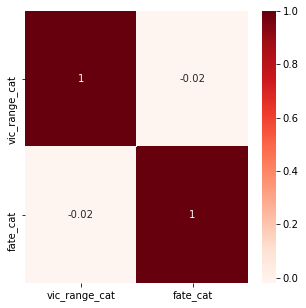

In [414]:
data['vic_range_cat']=data["num_vic_range"].astype("category").cat.codes
features=["vic_range_cat","fate_cat"]
correlation=data[features].corr().round(2)
plt.figure(1, figsize=(5,5))
sns.heatmap(data=correlation, cmap="Reds", annot=True)

## Third insight:
> - The fate of the shooter is not influenced by the amount of victims in the shooting. 

[Text(0, 0, 'White American or European American'),
 Text(0, 0, 'Black American or African American'),
 Text(0, 0, 'Some other race'),
 Text(0, 0, 'Asian American'),
 Text(0, 0, 'Native American or Alaska Native')]

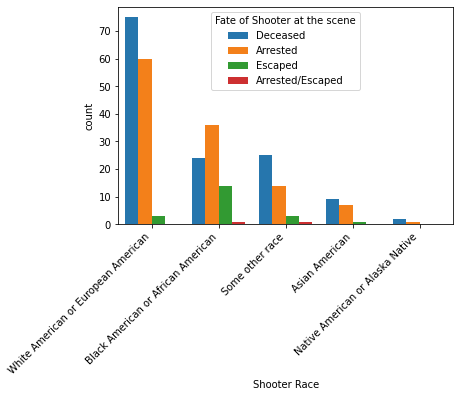

In [267]:
#t=sns.countplot(x=data['Shooter Race'],data=data,hue='Fate of Shooter at the scene',saturation=0.9)
#t.set_xticklabels(t.get_xticklabels(), rotation=45, ha="right")